## setup

In [28]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

In [29]:
soc = QickSoc('/home/xilinx/jupyter_notebooks/fw/2025-06-15_216_tprocv2r24_standard/qick_216.bit')
soccfg = soc
print(soccfg)

QICK running on ZCU216, software version 0.2.353

Firmware configuration (built Sun Jun 15 17:47:17 2025):

	Global clocks (MHz): tProc dispatcher timing 430.080, RF reference 245.760
	Groups of related clocks: [tProc core clock, tProc timing clock, DAC tile 1, DAC tile 2, DAC tile 3], [DAC tile 0], [ADC tile 2]

	16 signal generator channels:
	0:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 65536 complex samples (6.838 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 16384 complex samples (1.709 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 32768 complex samples (3.419 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 16384 complex samp

In [30]:
# ZCU216 standard FW, full-speed gen
GEN_CH = 0
RO_CH = 0
TRIG_TIME = 0.40
FREQ = 500


## basic multi-pulse program
Just a "reps" loop, no sweeping - like v1 AveragerProgram.

In v2, you define all of your pulses, and then you can play them as needed. Contrast to v1, where only one pulse could be defined on a generator at a time.

  0%|          | 0/10 [00:00<?, ?it/s]

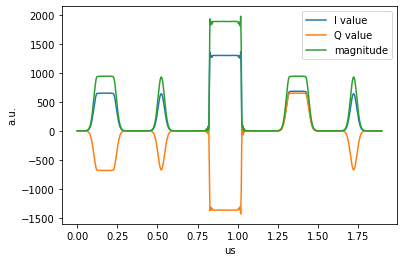

In [32]:
class MultiPulseProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myflattop", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mygaus", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=0.2, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                      )

        self.add_pulse(ch=gen_ch, name="myflattop2", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=90,
                       gain=1.0, 
                      )

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)
        # send the config to the dynamic RO
        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
        
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0.4)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0.8)
        self.pulse(ch=cfg['gen_ch'], name="myflattop2", t=1.2)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=1.6)
        
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 1.9,
         }

prog = MultiPulseProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, rounds=10)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")

In [ ]:
# print the program - ugly!
print(prog)

prog.print_pmem2hex()
prog.print_wmem2hex()

prog.print_sg_mem(sg_idx=0, gen_file=True)


macros:
	WriteReg(dst='s_core_w1', src=0)
	ConfigReadout(ch=0, name='myro', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff8f530c10>}, t_regs={'t': 0})
	Delay(t=1.0, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff8f530b80>}, t_regs={'t': 430})
	OpenLoop(n=1, name='reps')
	Trigger(ros=[0], pins=[0], t=0.4, width=0.023251488095238096, ddr4=True, mr=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff8f5309a0>, 'width': <qick.asm_v2.QickParam object at 0xffff8f530bb0>}, t_regs={'t': 172, 'width': 10}, outdict=defaultdict(<class 'int'>, {}), trigset={0, 9, 10})
	Pulse(ch=0, name='mygaus', t='auto', tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff8f530a60>}, t_regs={'t': 0})
	Pulse(ch=0, name='mygaus', t='auto', tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff8f530910>}, t_regs={'t': 2})
	Pulse(ch=0, name='mygaus2', t='auto', tag=None, t_params={'t': <qick.asm_v2.QickPar